# Figure out the magnitude limit of CPM method.

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from tess_stars2px import tess_stars2px_function_entry
import eleanor
import tess_rotation as tr
import starspot as ss
import starry
from contextlib import contextmanager

import warnings
warnings.filterwarnings('ignore')

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Define functions for injection and recovery.

In [2]:
# Calculate counts for a star of a certain magnitude
def mag_to_counts(mag, seconds):
    """
    Convert stellar magnitude to electron counts.
    
    "15,000 e−/s for a star of m = 10: thus, a star of m = 5 will create 3 × 106 electrons in a two-second exposure"
    10 x fainter is a magnitude increase of 2.5 
    
    F2/F1 approx 2.5^(delta m)
    delta m = 1
    F2/F1 = 2.5
    
    delta m = log(F2/F1)/log(2.5)
    for F2/F1 = 10, delta m = 2.5
    
    For a change of 1 mag, the change in brightness is 2.5.
    For a change of 2.5 mag, the change in brightness is 10.
    For a change of 5 mag, the change in brightness is 100.
    """
    m = 10
    e = 15000
    delta_m = m - mag
    factor = 2.51**delta_m
    counts_per_sec = e * factor
    return counts_per_sec * seconds

Instantiate injection class.

In [3]:
ticid = 765143490
tesscut_path = "/Users/rangus/projects/TESS-rotation/data/TESScut/"
star = tr.InjectStar(ticid, tesscut_path, upper_sector_limit=14)

Finding the sectors that star was observed in.
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
Found sectors [ 1  2  4  5  6  7  8  9 10 11 12]
Loading time arrays
sector 1
sector 2
sector 4
sector 5
sector 6
sector 7
sector 8
sector 9
sector 10
sector 11
sector 12


In [4]:
magnitude = 15
baseline = mag_to_counts(magnitude, 2)
print(baseline, baseline*.01)
period, amplitude = 50, baseline*.01  # 1% amplitude.

301.1290453376505 3.011290453376505


Pre-computing some matrices... Done.
Compiling `flux`... Done.
Pre-computing some matrices... Done.
Compiling `flux`... Done.


1.5035495512492443 %
1.799681269733663 %


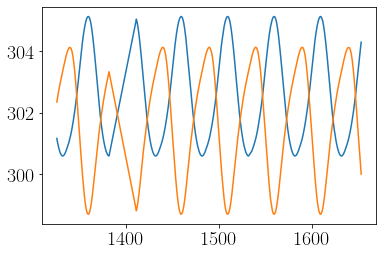

In [5]:
star.generate_signal(period, amplitude, baseline)
plt.plot(star.time_array, star.signal)
print((max(star.signal) - min(star.signal))/baseline*100, "%")
star.generate_signal(period, amplitude, baseline)
plt.plot(star.time_array, star.signal)
print((max(star.signal) - min(star.signal))/baseline*100, "%")

In [53]:
def loop(period, amplitude, baseline, nsamps=10):
    true_periods, recovered_periods, true_amp = [np.zeros(nsamps) for i in range(3)]

    for i in range(nsamps):
#         print(i, "of", nsamps)
        
        # Inject
        with suppress_stdout():
            star.generate_signal(period, amplitude, baseline)
            star.inject_signal()
        plt.plot(star.time_array, star.signal)

        # Recover
        with suppress_stdout():
            time_cpm, flux_cpm = star.CPM_recover()

        #  Stitch
        with suppress_stdout():
            time, flux, flux_err = tr.stitch_light_curve(ticid, time_cpm, flux_cpm)

        #  Measure
        p = np.polyfit(time, flux, 1)
        rotate = ss.RotationModel(time, flux-np.polyval(p, time), flux_err)
        ls_period = rotate.ls_rotation(max_period=200.)

        true_periods[i] = period
        recovered_periods[i] = ls_period
        true_amp[i] = (max(star.signal) - min(star.signal))/baseline*100
        
#         fig = plt.figure(figsize=(16, 8), dpi=200)
#         ax1 = fig.add_subplot(211)
#         xs = np.linspace(min(time), max(time), 1000)
#         ax1.errorbar(time, flux-np.polyval(p, time), yerr=flux_err, fmt="k.", alpha=.2, label="$\mathrm{Recovered~signal}$", rasterized=True)
#         ax1.legend(fontsize=18)
#         ax1.set_xlabel("$\mathrm{Time~[days]}$")
#         ax1.set_ylabel("$\mathrm{Flux~[arbitrary~units]}$");
#         ax2 = fig.add_subplot(212)
#         ax2.plot(1./rotate.freq, rotate.power)
#         ax2.set_xlabel("$\mathrm{Period~[days]}$")
#         ax2.set_ylabel("$\mathrm{Power}$");
#         plt.tight_layout()
#         plt.show()
    
    return true_periods, recovered_periods, true_amp

In [54]:
periods = np.array([50, 100, 120, 150, 170])
magnitudes = np.array([14.5, 14.85, 15, 15.25, 15.5])
baselines = mag_to_counts(magnitudes, 2)
amplitudes = baselines*.01
P, B = np.meshgrid(periods, baselines, indexing="ij")
_, A = np.meshgrid(periods, amplitudes, indexing="ij")
N = np.zeros_like(P)

Pre-computing some matrices... Done.
Compiling `flux`... Done.


0 of 5 periods, 0 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
188it [00:00, 789.95it/s, logp=4.478574e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.0207922968573 -> 4478.573605426487
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
135it [00:00, 779.89it/s, logp=4.459135e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 529.0949968273015 -> 4459.134867251049
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
49it [00:00, 683.48it/s, logp=4.507266e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.1383731944647 -> 4507.26561704778
Pre-computing some matrices...

0 of 5 periods, 1 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
136it [00:00, 727.57it/s, logp=4.312459e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 528.227348357944 -> 4312.459450642136
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
48it [00:00, 673.39it/s, logp=4.322041e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.8464863534139 -> 4322.040896657439
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
138it [00:00, 688.18it/s, logp=4.313354e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.3952587177083 -> 4313.354024112556
Pre-computing some matrices...

0 of 5 periods, 2 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
141it [00:00, 775.70it/s, logp=4.266622e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.6827860280657 -> 4266.621696615523
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
67it [00:00, 675.49it/s, logp=4.238248e+03] 
message: Optimization terminated successfully.
logp: 524.2888277467176 -> 4238.248411519688
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
118it [00:00, 654.62it/s, logp=4.275518e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.6727665760102 -> 4275.518429295931
Pre-computing some matrices... Done.
Compiling `flux

0 of 5 periods, 3 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
131it [00:00, 735.24it/s, logp=4.147426e+03]
message: Optimization terminated successfully.
logp: 524.7611653429102 -> 4147.426158058772
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
56it [00:00, 644.26it/s, logp=4.134977e+03]
message: Optimization terminated successfully.
logp: 522.7304687051935 -> 4134.976735729297
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
59it [00:00, 568.78it/s, logp=4.143956e+03]
message: Optimization terminated successfully.
logp: 523.14498387128 -> 4143.956251654487
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, s

0 of 5 periods, 4 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
58it [00:00, 707.00it/s, logp=4.087451e+03]
message: Optimization terminated successfully.
logp: 522.4639148505495 -> 4087.451069476673
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
61it [00:00, 714.90it/s, logp=4.096196e+03]
message: Optimization terminated successfully.
logp: 524.738166776728 -> 4096.196192087295
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
115it [00:00, 691.82it/s, logp=4.111247e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.0867681073789 -> 4111.246579897894
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp 

1 of 5 periods, 0 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
127it [00:00, 797.58it/s, logp=4.518942e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.0580510201863 -> 4518.941848636194
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
73it [00:00, 699.24it/s, logp=4.504236e+03]
message: Optimization terminated successfully.
logp: 526.9174245117349 -> 4504.235637062858
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
123it [00:00, 717.54it/s, logp=4.514450e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 528.7397648328798 -> 4514.449528007637
Pre-computing some matrices... Done.
Compiling `flux`

1 of 5 periods, 1 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
107it [00:00, 815.58it/s, logp=4.316298e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.9791811350016 -> 4316.297923425525
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
105it [00:00, 725.95it/s, logp=4.364213e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.5165722957668 -> 4364.212570623492
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
189it [00:00, 838.97it/s, logp=4.274985e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.9563951812391 -> 4274.985309475599
Pre-computing some matrices.

1 of 5 periods, 2 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
88it [00:00, 800.76it/s, logp=4.269375e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.493954078766 -> 4269.375122711835
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
74it [00:00, 743.72it/s, logp=4.268166e+03]
message: Optimization terminated successfully.
logp: 525.6786924309043 -> 4268.165663831417
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
45it [00:00, 624.12it/s, logp=4.260826e+03]
message: Optimization terminated successfully.
logp: 526.8403486610357 -> 4260.8259583821255
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp 

1 of 5 periods, 3 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
59it [00:00, 699.34it/s, logp=4.157110e+03]
message: Optimization terminated successfully.
logp: 524.1524456268811 -> 4157.11026011474
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
198it [00:00, 809.94it/s, logp=4.203628e+03]
message: Optimization terminated successfully.
logp: 524.7112815327715 -> 4203.627623937014
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
57it [00:00, 516.62it/s, logp=4.200208e+03]
message: Optimization terminated successfully.
logp: 524.9325701585973 -> 4200.2081968960665
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10,

1 of 5 periods, 4 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
58it [00:00, 674.04it/s, logp=4.098878e+03]
message: Optimization terminated successfully.
logp: 524.176424880012 -> 4098.878251956675
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
149it [00:00, 808.16it/s, logp=4.111752e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.4826402915841 -> 4111.752225293134
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
67it [00:00, 728.70it/s, logp=4.051397e+03]
message: Optimization terminated successfully.
logp: 520.7114206545892 -> 4051.3971944291998
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp

2 of 5 periods, 0 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
132it [00:00, 769.86it/s, logp=4.484884e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 528.1611340264536 -> 4484.883684940904
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
182it [00:00, 815.94it/s, logp=4.506731e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 529.6532834079886 -> 4506.73130768861
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
94it [00:00, 777.09it/s, logp=4.516299e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 529.3119088851714 -> 4516.298650730354
Pre-computing some matrices...

2 of 5 periods, 1 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
117it [00:00, 794.29it/s, logp=4.359242e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.4065851833532 -> 4359.242241181885
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
73it [00:00, 757.18it/s, logp=4.360295e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.6987286642125 -> 4360.295134933976
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
94it [00:00, 754.53it/s, logp=4.361209e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.7941992802474 -> 4361.20935032354
Pre-computing some matrices... 

2 of 5 periods, 2 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
88it [00:00, 780.90it/s, logp=4.258913e+03]
message: Optimization terminated successfully.
logp: 527.2497353680153 -> 4258.912501575356
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
132it [00:00, 780.77it/s, logp=4.262754e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.609782315854 -> 4262.753678489214
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
225it [00:00, 744.23it/s, logp=4.264692e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.9908095387618 -> 4264.69208354477
Pre-computing some matrices... Done.
Compiling `flux`..

2 of 5 periods, 3 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
123it [00:00, 797.64it/s, logp=4.122158e+03]
message: Optimization terminated successfully.
logp: 524.7114146154202 -> 4122.157953765615
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
104it [00:00, 785.64it/s, logp=4.151079e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.0527547014311 -> 4151.078576254117
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
143it [00:00, 811.08it/s, logp=4.171086e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.9420378487295 -> 4171.08635365188
Pre-computing some matrices... Done.
Compiling `flux`

2 of 5 periods, 4 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
61it [00:00, 696.18it/s, logp=4.068289e+03]
message: Optimization terminated successfully.
logp: 525.1908202747394 -> 4068.289471637525
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
59it [00:00, 708.47it/s, logp=4.051391e+03]
message: Optimization terminated successfully.
logp: 522.9404719453241 -> 4051.391339700654
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
59it [00:00, 659.17it/s, logp=4.107280e+03]
message: Optimization terminated successfully.
logp: 523.5667706831255 -> 4107.280011922549
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, 

3 of 5 periods, 0 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
127it [00:00, 815.34it/s, logp=4.545781e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.2843440863203 -> 4545.780538088069
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
56it [00:00, 696.08it/s, logp=4.535771e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.7547961734887 -> 4535.771351822372
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
98it [00:00, 749.03it/s, logp=4.522022e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.2115163897175 -> 4522.022422796291
Pre-computing some matrices...

3 of 5 periods, 1 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
133it [00:00, 821.96it/s, logp=4.373386e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.2959108426642 -> 4373.385692530825
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
218it [00:00, 616.38it/s, logp=4.323928e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.6841189708173 -> 4323.927980548271
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
186it [00:00, 870.78it/s, logp=4.372643e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.4273900477966 -> 4372.643359319693
Pre-computing some matrices.

3 of 5 periods, 2 of 5 baselines


Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
114it [00:00, 810.96it/s, logp=4.282969e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.5734402870663 -> 4282.968925249939
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
121it [00:00, 811.39it/s, logp=4.276519e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.152841804055 -> 4276.518874960907
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
93it [00:00, 802.24it/s, logp=4.295365e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.3593765117561 -> 4295.364613547334
Pre-computing some matri

3 of 5 periods, 3 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
156it [00:00, 791.41it/s, logp=4.206283e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.02535496354 -> 4206.28336431906
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
95it [00:00, 707.22it/s, logp=4.175037e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.7368079980345 -> 4175.036642517813
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
72it [00:00, 746.01it/s, logp=4.218929e+03]
message: Optimization terminated successfully.
logp: 525.5857664370543 -> 4218.928514626763
Pre-computing some matrices... Done.
Compiling `flux`... 

3 of 5 periods, 4 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
218it [00:00, 771.72it/s, logp=4.065282e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 522.935533482437 -> 4065.281616946747
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
61it [00:00, 621.76it/s, logp=4.096778e+03]
message: Optimization terminated successfully.
logp: 524.4487563576616 -> 4096.777988800436
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
59it [00:00, 696.94it/s, logp=4.091335e+03] 
message: Optimization terminated successfully.
logp: 523.3755579933237 -> 4091.3352579069324
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing log

4 of 5 periods, 0 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
120it [00:00, 825.42it/s, logp=4.531913e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.9593128843519 -> 4531.9126337384105
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
108it [00:00, 813.90it/s, logp=4.534616e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.2821042234771 -> 4534.615857584941
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
134it [00:00, 732.65it/s, logp=4.522271e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.3423075524336 -> 4522.270694462365
Pre-computing some matrices

4 of 5 periods, 1 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
106it [00:00, 750.56it/s, logp=4.398847e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.535430664497 -> 4398.847242020069
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
86it [00:00, 770.74it/s, logp=4.363415e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.9239310216653 -> 4363.41506553741
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
154it [00:00, 779.73it/s, logp=4.344459e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.2975254801628 -> 4344.459447618809
Pre-computing some matrices... 

4 of 5 periods, 2 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
192it [00:00, 767.59it/s, logp=4.245436e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.5193487180071 -> 4245.4361250006295
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
75it [00:00, 682.25it/s, logp=4.301325e+03]
message: Optimization terminated successfully.
logp: 526.9879291383538 -> 4301.325190013493
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
99it [00:00, 713.79it/s, logp=4.252976e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 526.2742438625687 -> 4252.9760059731125
Pre-computing some matrices... Done.
Compiling `flu

4 of 5 periods, 3 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
60it [00:00, 539.02it/s, logp=4.162835e+03]
message: Optimization terminated successfully.
logp: 524.548076553391 -> 4162.834661333406
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
123it [00:00, 607.96it/s, logp=4.195097e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.4419836598296 -> 4195.09674329652
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
140it [00:00, 554.84it/s, logp=4.180896e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.7286630433814 -> 4180.89583271183
Pre-computing some matrices... Done.
Compiling `flux`...

4 of 5 periods, 4 of 5 baselines


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
170it [00:00, 747.59it/s, logp=4.108679e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.1740776946131 -> 4108.678765080292
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
112it [00:00, 696.49it/s, logp=4.119297e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.9065614324718 -> 4119.297246404483
Pre-computing some matrices... Done.
Compiling `flux`... Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
60it [00:00, 584.44it/s, logp=4.102637e+03] 
message: Optimization terminated successfully.
logp: 522.7177405438871 -> 4102.6373902991045
Pre-computing some matrices... Done.
Compiling `flu

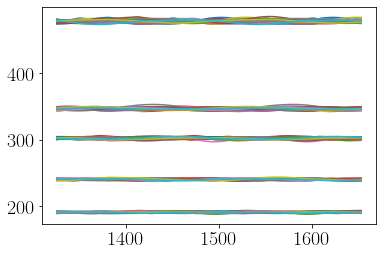

In [55]:
for i, p in enumerate(periods):
    for j, b in enumerate(baselines):
        print(f"{i} of {len(periods)} periods, {j} of {len(baselines)} baselines")
        true, recovered, amp = loop(P[i, j], A[i, j], B[i, j], nsamps=10)
        relative = true/recovered
        correct_mask = (.9 < relative) & (relative < 1.1)
        N[i, j] = len(true[correct_mask])

In [56]:
N

array([[9, 8, 8, 4, 4],
       [9, 6, 7, 9, 8],
       [5, 4, 7, 6, 6],
       [8, 9, 6, 7, 4],
       [3, 2, 2, 4, 4]])

In [63]:
print((8 + 7 + 7 + 6) / 40 * 100)

70.0


In [57]:
P

array([[ 50,  50,  50,  50,  50],
       [100, 100, 100, 100, 100],
       [120, 120, 120, 120, 120],
       [150, 150, 150, 150, 150],
       [170, 170, 170, 170, 170]])

In [62]:
B

array([[477.07812975, 345.70344352, 301.12904534, 239.24023313,
        190.07096803],
       [477.07812975, 345.70344352, 301.12904534, 239.24023313,
        190.07096803],
       [477.07812975, 345.70344352, 301.12904534, 239.24023313,
        190.07096803],
       [477.07812975, 345.70344352, 301.12904534, 239.24023313,
        190.07096803],
       [477.07812975, 345.70344352, 301.12904534, 239.24023313,
        190.07096803]])

Pre-computing some matrices... Done.
Compiling `flux`... Done.


0 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
65it [00:00, 91.17it/s, logp=4.253984e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 523.0482306743285 -> 4253.984211473586
Pre-computing some matrices... Done.
Compiling `flux`... Done.


1 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
90it [00:00, 699.45it/s, logp=4.274759e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.9355372281275 -> 4274.758839455078
Pre-computing some matrices... Done.
Compiling `flux`... Done.


2 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
134it [00:00, 709.93it/s, logp=4.242238e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.5374944900298 -> 4242.238300740322
Pre-computing some matrices... Done.
Compiling `flux`... Done.


3 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
158it [00:00, 744.91it/s, logp=4.214732e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.1887806418857 -> 4214.731848865621
Pre-computing some matrices... Done.
Compiling `flux`... Done.


4 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
133it [00:00, 758.75it/s, logp=4.223071e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.2382955810648 -> 4223.071478416823
Pre-computing some matrices... Done.
Compiling `flux`... Done.


5 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
220it [00:00, 789.33it/s, logp=4.206863e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.1974386225475 -> 4206.862940824908
Pre-computing some matrices... Done.
Compiling `flux`... Done.


6 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
153it [00:00, 841.29it/s, logp=4.227924e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.697433006452 -> 4227.92429313354
Pre-computing some matrices... Done.
Compiling `flux`... Done.


7 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
123it [00:00, 811.47it/s, logp=4.279017e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.0069831549195 -> 4279.01677627272
Pre-computing some matrices... Done.
Compiling `flux`... Done.


8 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
49it [00:00, 695.82it/s, logp=4.270609e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.3829424443296 -> 4270.608980684564
Pre-computing some matrices... Done.
Compiling `flux`... Done.


9 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
61it [00:00, 722.67it/s, logp=4.224655e+03]
message: Optimization terminated successfully.
logp: 526.430220423181 -> 4224.654569982588
Pre-computing some matrices... Done.
Compiling `flux`... Done.


10 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
68it [00:00, 713.72it/s, logp=4.211554e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 528.3298684629141 -> 4211.554436457648
Pre-computing some matrices... Done.
Compiling `flux`... Done.


11 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
119it [00:00, 762.38it/s, logp=4.218514e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 523.2882616658952 -> 4218.514238962665
Pre-computing some matrices... Done.
Compiling `flux`... Done.


12 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
81it [00:00, 737.81it/s, logp=4.291271e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.6707157970359 -> 4291.271396297092
Pre-computing some matrices... Done.
Compiling `flux`... Done.


13 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
127it [00:00, 803.04it/s, logp=4.218061e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.6219459213094 -> 4218.06115570673
Pre-computing some matrices... Done.
Compiling `flux`... Done.


14 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
127it [00:00, 740.22it/s, logp=4.242128e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.5242566901717 -> 4242.128113995325
Pre-computing some matrices... Done.
Compiling `flux`... Done.


15 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
127it [00:00, 748.77it/s, logp=4.254879e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.9614369368137 -> 4254.8790926382
Pre-computing some matrices... Done.
Compiling `flux`... Done.


16 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
48it [00:00, 656.72it/s, logp=4.236435e+03]
message: Optimization terminated successfully.
logp: 525.2628860755713 -> 4236.434632913197
Pre-computing some matrices... Done.
Compiling `flux`... Done.


17 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
80it [00:00, 761.30it/s, logp=4.251213e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.1036248143687 -> 4251.213377005358
Pre-computing some matrices... Done.
Compiling `flux`... Done.


18 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
74it [00:00, 727.83it/s, logp=4.238733e+03] 
message: Optimization terminated successfully.
logp: 526.6600013807938 -> 4238.732529009803
Pre-computing some matrices... Done.
Compiling `flux`... Done.


19 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
126it [00:00, 825.48it/s, logp=4.177775e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.0982386121586 -> 4177.774532385237


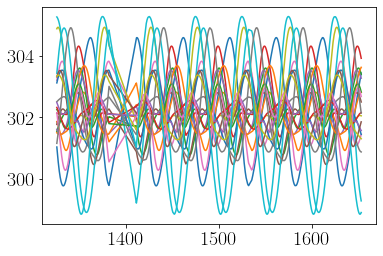

In [7]:
true50, recovered50, amp50 = loop(period, amplitude, baseline, nsamps=10)mag_to_counts

In [9]:
relative = true50/recovered50
correct_mask = (.9 < relative) & (relative < 1.1)
print(len(true50[correct_mask]), "correct out of 20")

11 correct out of 20


NameError: name 'true_amp' is not defined

Pre-computing some matrices... Done.
Compiling `flux`... Done.


0 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
43it [00:00, 576.56it/s, logp=4.276370e+03]
message: Optimization terminated successfully.
logp: 527.0846139000791 -> 4276.369888518531
Pre-computing some matrices... Done.
Compiling `flux`... Done.


1 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
111it [00:00, 691.03it/s, logp=4.254254e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.7757294517327 -> 4254.2535758092745
Pre-computing some matrices... Done.
Compiling `flux`... Done.


2 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
98it [00:00, 694.74it/s, logp=4.267139e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.0393355310964 -> 4267.139137680827
Pre-computing some matrices... Done.
Compiling `flux`... Done.


3 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
127it [00:00, 785.68it/s, logp=4.274095e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.2148178863328 -> 4274.094805293509
Pre-computing some matrices... Done.
Compiling `flux`... Done.


4 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
173it [00:00, 593.43it/s, logp=4.268518e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.6130709590498 -> 4268.518087329245
Pre-computing some matrices... Done.
Compiling `flux`... Done.


5 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
110it [00:00, 758.67it/s, logp=4.239317e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.1285520592883 -> 4239.316803370954
Pre-computing some matrices... Done.
Compiling `flux`... Done.


6 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
125it [00:00, 766.27it/s, logp=4.271968e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.3213522578612 -> 4271.967512580971
Pre-computing some matrices... Done.
Compiling `flux`... Done.


7 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
124it [00:00, 703.21it/s, logp=4.250708e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.0509329639444 -> 4250.708426031339
Pre-computing some matrices... Done.
Compiling `flux`... Done.


8 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
134it [00:00, 674.25it/s, logp=4.265041e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.5691378333499 -> 4265.041078787243
Pre-computing some matrices... Done.
Compiling `flux`... Done.


9 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
63it [00:00, 587.93it/s, logp=4.287501e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.5176542047484 -> 4287.500770801182
Pre-computing some matrices... Done.
Compiling `flux`... Done.


10 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
144it [00:00, 700.28it/s, logp=4.280713e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.7948599117888 -> 4280.713280067917
Pre-computing some matrices... Done.
Compiling `flux`... Done.


11 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
103it [00:00, 691.62it/s, logp=4.306865e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.8079153252797 -> 4306.865168233745
Pre-computing some matrices... Done.
Compiling `flux`... Done.


12 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
121it [00:00, 687.91it/s, logp=4.285398e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.4882868906841 -> 4285.3977080845425
Pre-computing some matrices... Done.
Compiling `flux`... Done.


13 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
47it [00:00, 615.21it/s, logp=4.234368e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.8450916804878 -> 4234.368098175355
Pre-computing some matrices... Done.
Compiling `flux`... Done.


14 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
93it [00:00, 752.31it/s, logp=4.268000e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.7244922212086 -> 4268.000387165247
Pre-computing some matrices... Done.
Compiling `flux`... Done.


15 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
124it [00:00, 789.45it/s, logp=4.272944e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 528.8807292960298 -> 4272.9435999050875
Pre-computing some matrices... Done.
Compiling `flux`... Done.


16 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
123it [00:00, 773.25it/s, logp=4.260617e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.7903889763109 -> 4260.617195420015
Pre-computing some matrices... Done.
Compiling `flux`... 

17 of 20
Injecting...


Done.


Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
149it [00:00, 703.97it/s, logp=4.234403e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.3306033122979 -> 4234.40317480874
Pre-computing some matrices... Done.
Compiling `flux`... Done.


18 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
51it [00:00, 538.63it/s, logp=4.267392e+03]
message: Optimization terminated successfully.
logp: 526.3306252031834 -> 4267.392077623885
Pre-computing some matrices... Done.
Compiling `flux`... Done.


19 of 20
Injecting...
Recovering...
Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
96it [00:00, 657.59it/s, logp=4.315495e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.7684507061014 -> 4315.494585893546


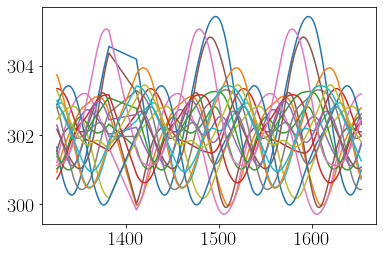

In [11]:
true100, recovered100, amp100 = loop(100, amplitude, baseline, nsamps=20)

In [12]:
relative = true100/recovered100
correct_mask = (.9 < relative) & (relative < 1.1)
print(len(true100[correct_mask]), "correct out of 20")
print(amp100)

12 correct out of 20
[1.70850137 1.04488289 0.5955716  0.61548609 0.50130123 1.09830751
 1.15566627 0.95398086 0.88147807 0.80827095 1.14130134 1.15279148
 0.75117123 0.8422273  0.61764324 1.25934637 1.30564254 0.54848836
 0.59681618 0.82161149]


Pre-computing some matrices... Done.
Compiling `flux`... Done.


0 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
182it [00:00, 810.59it/s, logp=4.259697e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.3589191305467 -> 4259.696594724423
Pre-computing some matrices... Done.
Compiling `flux`... 

1 of 10


Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
67it [00:00, 500.00it/s, logp=4.254013e+03]
message: Optimization terminated successfully.
logp: 526.6473929460523 -> 4254.013213941941
Pre-computing some matrices... Done.
Compiling `flux`... Done.


2 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
111it [00:00, 640.56it/s, logp=4.262448e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.9796640101542 -> 4262.447998194673
Pre-computing some matrices... Done.
Compiling `flux`... Done.


3 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
118it [00:00, 733.83it/s, logp=4.291920e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.3388411753102 -> 4291.920367989208
Pre-computing some matrices... Done.
Compiling `flux`... Done.


4 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
164it [00:00, 593.61it/s, logp=4.271983e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.729688969681 -> 4271.982920663915
Pre-computing some matrices... Done.
Compiling `flux`... Done.


5 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
47it [00:00, 420.99it/s, logp=4.276174e+03]
message: Optimization terminated successfully.
logp: 525.7800722824541 -> 4276.173998764072
Pre-computing some matrices... Done.
Compiling `flux`... Done.


6 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
40it [00:00, 579.98it/s, logp=4.302728e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.881389576498 -> 4302.727722397608
Pre-computing some matrices... Done.
Compiling `flux`... Done.


7 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
121it [00:00, 727.71it/s, logp=4.260656e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.6150465611493 -> 4260.655504590201
Pre-computing some matrices... Done.
Compiling `flux`... Done.


8 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
55it [00:00, 522.61it/s, logp=4.284525e+03]
message: Optimization terminated successfully.
logp: 526.1191964220368 -> 4284.525400326641
Pre-computing some matrices... Done.
Compiling `flux`... Done.


9 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
88it [00:00, 521.75it/s, logp=4.293486e+03]
message: Optimization terminated successfully.
logp: 526.1438297522182 -> 4293.485869530588


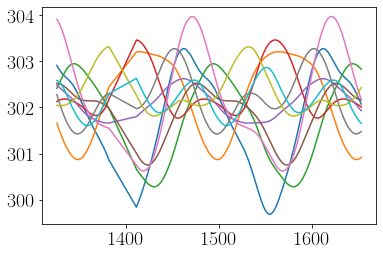

In [14]:
true150, recovered150, amp150 = loop(150, amplitude, baseline, nsamps=10)

In [16]:
relative = true150/recovered150
correct_mask = (.9 < relative) & (relative < 1.1)
print(len(true150[correct_mask]), "correct out of 10")
print(amp150)

2 correct out of 10
[1.19305324 0.77755662 0.88652682 0.56317869 0.31948196 0.58897549
 1.11305116 0.61417396 0.49948342 0.41857336]


Pre-computing some matrices... Done.
Compiling `flux`... Done.


0 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
76it [00:00, 673.32it/s, logp=4.291445e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.1899897546639 -> 4291.4454510239675
Pre-computing some matrices... Done.
Compiling `flux`... Done.


1 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
103it [00:00, 758.40it/s, logp=4.303356e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 527.4854548270962 -> 4303.356488386
Pre-computing some matrices... Done.
Compiling `flux`... Done.


2 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
108it [00:00, 753.87it/s, logp=4.294551e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.8118534624028 -> 4294.551335848327
Pre-computing some matrices... Done.
Compiling `flux`... Done.


3 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
130it [00:00, 712.77it/s, logp=4.259218e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.3455115523617 -> 4259.217739119039
Pre-computing some matrices... Done.
Compiling `flux`... Done.


4 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
105it [00:00, 634.54it/s, logp=4.264768e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.666926607086 -> 4264.767611498057
Pre-computing some matrices... Done.
Compiling `flux`... Done.


5 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
103it [00:00, 591.28it/s, logp=4.235190e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 526.1343834984075 -> 4235.190022773102
Pre-computing some matrices... Done.
Compiling `flux`... Done.


6 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
82it [00:00, 589.05it/s, logp=4.279191e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 524.6613690268168 -> 4279.191016643028
Pre-computing some matrices... Done.
Compiling `flux`... Done.


7 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
70it [00:00, 670.65it/s, logp=4.261146e+03]
message: Optimization terminated successfully.
logp: 525.7873669337491 -> 4261.146023538127
Pre-computing some matrices... Done.
Compiling `flux`... 

8 of 10


Done.
optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
142it [00:00, 767.56it/s, logp=4.271696e+03]
message: Optimization terminated successfully.
logp: 526.0443842366209 -> 4271.696438133453
Pre-computing some matrices... Done.
Compiling `flux`... Done.


9 of 10


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
47it [00:00, 403.76it/s, logp=4.248699e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 525.844569803722 -> 4248.699060225921


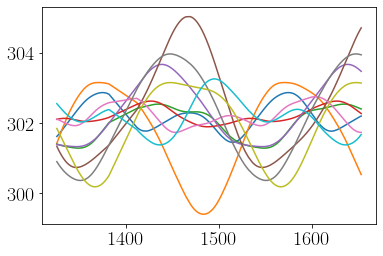

In [17]:
true200, recovered200, amp200 = loop(200, amplitude, baseline, nsamps=10)

In [20]:
relative = true200/recovered200
correct_mask = (.9 < relative) & (relative < 1.1)
print(len(true200[correct_mask]), "correct out of 20")
print(amp200)

0 correct out of 20
[0.46994951 1.24430043 0.41600664 0.2429488  0.77716933 1.4261584
 0.33689239 1.19555573 0.98474881 0.62355282]


In [7]:
print(true, recovered)

[50. 50.] [88.77555097 89.40895618]


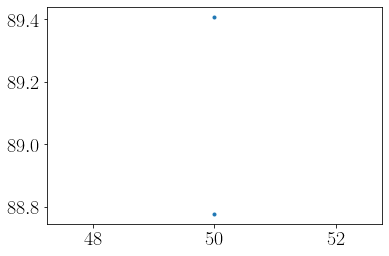

In [8]:
plt.plot(true, recovered, ".");